## Install Libraries

In [1]:
!pip install adversarial-robustness-toolbox

%matplotlib inline 

from __future__ import absolute_import, division, print_function, unicode_literals
from os.path import abspath
import os
import time
import sys
sys.path.append(abspath('.'))
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

import art
from art.classifiers import KerasClassifier
from art.attacks import DeepFool, BasicIterativeMethod, FastGradientMethod, SaliencyMapMethod, CarliniL2Method, NewtonFool, UniversalPerturbation
from art.defences import SpatialSmoothing, FeatureSqueezing, GaussianAugmentation, LabelSmoothing
from art.utils import load_mnist_raw, preprocess, random_targets

from google.colab import files

import time
start_time = time.time()

    100% |████████████████████████████████| 133kB 5.7MB/s 


Using TensorFlow backend.


## Attack/Defense Functions

### Utility Functions

In [0]:
def create_nn(min_, max_):
    """ Create a simple 2 hidden layer 64 node neural net. """
    model = Sequential()
    model.add(Dense(64, input_dim=784, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier((min_, max_), model=model)
    return classifier

def extract_num(matrix, i):
    return matrix[i].reshape(28,28)

def plot(matrix, i, title=None):
    img = extract_num(matrix, i)
    plt.viridis()
    plt.grid(False)
    plt.imshow(img, interpolation='nearest')
    if title:
        plt.title(title, fontsize=32)

def plot_all_adv(name, adv, start, end, height):
    assert(end > start)
    columns = len(adv.keys())
    rows = end - start
    fig = plt.figure(figsize=(15, rows*height))
    
    for row in range(rows):
        for col, attack in enumerate(adv.keys()):
            fig.add_subplot(rows, columns, (row * len(adv.keys())) + col + 1)
            img = extract_num(adv[attack], start + row)
            plt.viridis()
            plt.grid(False)
            plt.imshow(img, interpolation='nearest')
            plt.title(attack, fontsize=12)
    fig.suptitle(name, fontsize=22)

def evaluate(x_train, x_test, y_train, y_test, classifier, attack=None, defense=None):
    if not attack:
        attack = 'Baseline'
    if not defense:
        defense = 'No Defense'
        
    print('[Evaluate] Attack: ' + attack + ' Defense: ' + defense)
    
    preds = np.argmax(classifier.predict(x_train), axis=1)
    acc = np.sum(preds == np.argmax(y_train, axis=1)) / y_train.shape[0]
    results[attack + ' (Train)'][defense] = (acc * 100)
    
    preds = np.argmax(classifier.predict(x_test), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    results[attack + ' (Test)'][defense] = (acc * 100)

### Attack Functions

In [0]:
attack_list = ["DeepFool", "BasicIterative", "FGSM", "JSMA", "CarliniL2", "NewtonFool", "UniPerturb"]

def atk_DeepFool(x_train, x_test, y_train, y_test, classifier):
    #print('Create DeepFool attack \n')
    adv_crafter = DeepFool(classifier, max_iter=15)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="DeepFool")
    return x_test_adv, x_train_adv

def atk_BasicIterative(x_train, x_test, y_train, y_test, classifier):
    #print('Create BasicIterativeMethod attack \n')
    adv_crafter = BasicIterativeMethod(classifier, eps=1, eps_step=0.1)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="BasicIterative")
    return x_test_adv, x_train_adv

def atk_FastGradient(x_train, x_test, y_train, y_test, classifier):
    epsilon = 0.1
    #print('Create FastGradientMethod attack \n')
    adv_crafter = FastGradientMethod(classifier)
    x_train_adv = adv_crafter.generate(x_train, eps=epsilon)
    x_test_adv = adv_crafter.generate(x_test, eps=epsilon)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="FGSM")
    return x_test_adv, x_train_adv

def atk_JSMA(x_train, x_test, y_train, y_test, classifier):
    #print('Create JSMA attack \n')
    adv_crafter = SaliencyMapMethod(classifier, theta=1, gamma = 0.5)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="JSMA")
    return x_test_adv, x_train_adv

def atk_CarliniL2(x_train, x_test, y_train, y_test, classifier):
    #print('Create CarliniL2Method attack \n')
    adv_crafter = CarliniL2Method(classifier, targeted=True, max_iter=10, binary_search_steps=1, learning_rate=1, initial_const=10, decay=0)
    params = {'y': random_targets(y_test, classifier.nb_classes)}
    x_train_adv = adv_crafter.generate(x_train, **params)
    x_test_adv = adv_crafter.generate(x_test, **params)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="CarliniL2")
    return x_test_adv, x_train_adv

def atk_NewtonFool(x_train, x_test, y_train, y_test, classifier):
    adv_crafter = NewtonFool(classifier, max_iter=20)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)

    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="NewtonFool")
    return x_test_adv, x_train_adv

def atk_UniPerturb(x_train, x_test, y_train, y_test, classifier):
    attack_params = {"attacker": "fgsm", "attacker_params": {"max_iter": 3}}
    adv_crafter = UniversalPerturbation(classifier)
    x_train_adv = adv_crafter.generate(x_train, **attack_params)
    x_test_adv = adv_crafter.generate(x_test, **attack_params)

    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="UniPerturb")
    return x_test_adv, x_train_adv

### Defense Functions

In [0]:
def def_SpatialSmoothing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    train_num = 60000
    test_num = 10000
    # reshape to smooth
    x_train = x_train.reshape(train_num, 28, 28, 1)
    x_test = x_test.reshape(test_num, 28, 28, 1)
    x_train_adv = x_train_adv.reshape(7*train_num, 28, 28, 1)
    x_test_adv = x_test_adv.reshape(7*test_num, 28, 28, 1)
    # smooth
    smoother = SpatialSmoothing()
    x_train_smooth = smoother(x_train, window_size=3)
    x_test_smooth = smoother(x_test, window_size=3)
    x_train_adv_smooth = smoother(x_train_adv, window_size=3)
    x_test_adv_smooth = smoother(x_test_adv, window_size=3)
    # reshape back
    x_train_smooth = x_train_smooth.reshape(train_num, 784)
    x_test_smooth = x_test_smooth.reshape(test_num, 784)
    x_train_adv_smooth = x_train_adv_smooth.reshape(7*train_num, 784)
    x_test_adv_smooth = x_test_adv_smooth.reshape(7*test_num, 784)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_smooth, y_train, nb_epochs=5, batch_size=50)
    
    evaluate(x_train_smooth, x_test_smooth, y_train, y_test, classifier, attack='_No Attack', defense="Spatial Smoothing")
    for k in range(7):
        evaluate(x_train_adv_smooth[k*train_num:(k+1)*train_num],
                x_test_adv_smooth[k*test_num:(k+1)*test_num],
                y_train,
                y_test,
                classifier,
                attack=attack_list[k],
                defense="Spatial Smoothing")
    K.clear_session()

def def_AdversarialTraining(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    train_num = 60000
    test_num = 10000
    
    classifier = create_nn(min_, max_)
    classifier.fit(x_train, y_train, nb_epochs=5, batch_size=50)
    evaluate(x_train, x_test, y_train, y_test, classifier, attack='_No Attack', defense="Adversarial Training")
    K.clear_session()
    
    for k in range (7):
        # expand the training set with the adversarial samples
        x_train_aug = np.append(x_train, x_train_adv[k*train_num:(k+1)*train_num], axis=0)
        y_train_aug = np.append(y_train, y_train, axis=0)
        # retrain the Network on the extended dataset
        classifier = create_nn(min_, max_)
        classifier.fit(x_train_aug, y_train_aug, nb_epochs=5, batch_size=50)
        
        evaluate(x_train_adv[k*train_num:(k+1)*train_num],
                 x_test_adv[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Adversarial Training")
        K.clear_session()

def def_FeatureSqueezing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    train_num = 60000
    test_num = 10000
    squeezer = FeatureSqueezing()
    x_train_squeeze = squeezer(x_train, bit_depth=2)
    x_test_squeeze = squeezer(x_test, bit_depth=2)
    x_train_adv_squeeze = squeezer(x_train_adv[0:6*train_num], bit_depth=2)
    x_test_adv_squeeze = squeezer(x_test_adv[0:6*test_num], bit_depth=2)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_squeeze, y_train, nb_epochs=5, batch_size=50)
    
    evaluate(x_train_squeeze,  x_test_squeeze, y_train, y_test, classifier, attack='_No Attack', defense="Feature Squeezing")
    for k in range (6):
        evaluate(x_train_adv_squeeze[k*train_num:(k+1)*train_num],
                 x_test_adv_squeeze[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Feature Squeezing")
    K.clear_session()

def def_GaussianAugmentation(x_raw_train, x_raw_test, y_raw_train, y_raw_test, x_train_adv, x_test_adv, y_train, y_test, min_, max_):
    train_num = 60000
    test_num = 10000
    # gaussian augmentation
    ga = GaussianAugmentation(sigma=150)
    x_train_aug, y_train_aug = ga(x_raw_train, y_raw_train)
    x_test_aug, y_test_aug = ga(x_raw_test, y_raw_test)
    x_train_aug, y_train_aug = preprocess(x_train_aug, y_train_aug)
    x_test_aug, y_test_aug = preprocess(x_test_aug, y_test_aug)
    x_train_aug = x_train_aug.reshape(2*train_num, 784)
    x_test_aug = x_test_aug.reshape(2*test_num, 784)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_aug, y_train_aug, nb_epochs=5, batch_size=50)
    
    # print result
    evaluate(x_train_aug, x_test_aug, y_train_aug, y_test_aug, classifier, attack='_No Attack', defense="Gaussian Augmentation")
    for k in range (7):
        evaluate(x_train_adv[k*train_num:(k+1)*train_num],
                 x_test_adv[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Gaussian Augmentation")
    K.clear_session()

def def_LabelSmoothing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    labelsmoother = LabelSmoothing()
    x_train, y_train_smooth = labelsmoother(x_train, y_train, max_value=.8)
    x_test, y_test_smooth = labelsmoother(x_test, y_test, max_value=.8)
    
     # train network on smoothed labels
    classifier = create_nn(min_, max_)
    classifier.fit(x_train, y_train_smooth, nb_epochs=5, batch_size=50)
    
    train_num = 60000
    test_num = 10000
    evaluate(x_train, x_test, y_train_smooth, y_test_smooth, classifier, attack='_No Attack', defense="Label Smoothing")
    for k in range (7):
        evaluate(x_train_adv[k*train_num:(k+1)*train_num],
                 x_test_adv[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Label Smoothing")
    K.clear_session()

## Create Baseline Network

### Read MNIST dataset (x_raw contains the original images):

11493376/11490434 [==============================] - 1s 0us/step
Epoch 1/5
1200/1200 [==============================] - 4s 4ms/step - loss: 0.0138 - acc: 0.9092
Epoch 2/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0064 - acc: 0.9590
Epoch 3/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0049 - acc: 0.9695
Epoch 4/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0039 - acc: 0.9754
Epoch 5/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0033 - acc: 0.9792


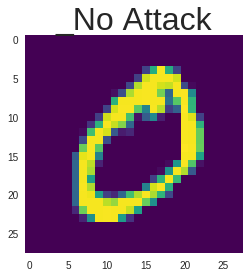

In [5]:
adv_test = {}
adv_train = {}

(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist_raw()
x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

adv_test['_No Attack'] = x_test
adv_train['_No Attack'] = x_train

plot(adv_train['_No Attack'], 1, '_No Attack')

classifier = create_nn(min_, max_)
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=50)

## Construct Adversarial Images on MNIST

In [0]:
results = defaultdict(dict)

adv_path = 'adv'
if not os.path.exists(adv_path):
   os.makedirs(adv_path)

### Deepfool

[Evaluate] Attack: DeepFool Defense: No Defense
--- 21.541990439097088 minutes ---


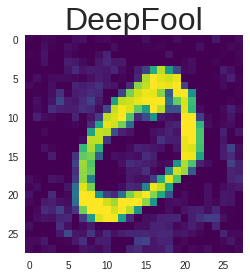

In [7]:
adv_test['DeepFool'], adv_train['DeepFool'] = atk_DeepFool(x_train, x_test, y_train, y_test, classifier)
np.save('adv/test_DeepFool', adv_test['DeepFool'])
np.save('adv/train_DeepFool', adv_train['DeepFool'])

adv_test['DeepFool'] = np.load('adv/test_DeepFool.npy')
adv_train['DeepFool'] = np.load('adv/train_DeepFool.npy')

plot(adv_train['DeepFool'], 1, 'DeepFool')
print("--- %s minutes ---" % ((time.time() - start_time)/60))

### BasicIterative

[Evaluate] Attack: BasicIterative Defense: No Defense
--- 22.60268739461899 minutes ---


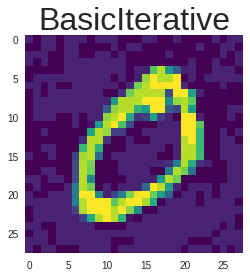

In [8]:
adv_test['BasicIterative'], adv_train['BasicIterative'] = atk_BasicIterative(x_train, x_test, y_train, y_test, classifier)
np.save('adv/test_BasicIterative', adv_test['BasicIterative'])
np.save('adv/train_BasicIterative', adv_train['BasicIterative'])
    
adv_test['BasicIterative'] = np.load('adv/test_BasicIterative.npy')
adv_train['BasicIterative'] = np.load('adv/train_BasicIterative.npy')

plot(adv_train['BasicIterative'], 1, 'BasicIterative')
print("--- %s minutes ---" % ((time.time() - start_time)/60))

### FGSM

[Evaluate] Attack: FGSM Defense: No Defense
--- 22.66472925345103 minutes ---


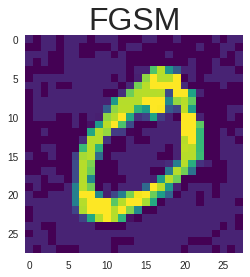

In [9]:
adv_test['FGSM'], adv_train['FGSM'] = atk_FastGradient(x_train, x_test, y_train, y_test, classifier)
np.save('adv/test_FGSM', adv_test['FGSM'])
np.save('adv/train_FGSM', adv_train['FGSM'])

adv_test['FGSM'] = np.load('adv/test_FGSM.npy')
adv_train['FGSM'] = np.load('adv/train_FGSM.npy')

plot(adv_train['FGSM'], 1, 'FGSM')
print("--- %s minutes ---" % ((time.time() - start_time)/60))

### JSMA
Slow but strong adversarial examples. Preceded FGSM.

[Evaluate] Attack: JSMA Defense: No Defense
--- 35.07880442539851 minutes ---


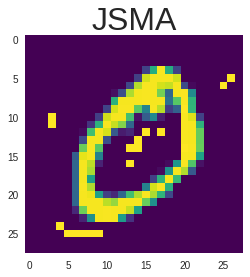

In [10]:
adv_test['JSMA'], adv_train['JSMA'] = atk_JSMA(x_train, x_test, y_train, y_test, classifier)
np.save('adv/test_JSMA', adv_test['JSMA'])
np.save('adv/train_JSMA', adv_train['JSMA'])

adv_test['JSMA'] = np.load('adv/test_JSMA.npy')
adv_train['JSMA'] = np.load('adv/train_JSMA.npy')

plot(adv_train['JSMA'], 1, 'JSMA')
print("--- %s minutes ---" % ((time.time() - start_time)/60))

### Carlini (L2)
Slow but considered one of the best iterative attacks.

[Evaluate] Attack: CarliniL2 Defense: No Defense
--- 39.177973834673566 minutes ---


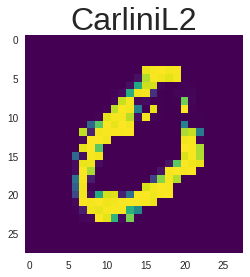

In [11]:
adv_test['CarliniL2'], adv_train['CarliniL2'] = atk_CarliniL2(x_train, x_test, y_train, y_test, classifier)
np.save('adv/test_CarliniL2', adv_test['CarliniL2'])
np.save('adv/train_CarliniL2', adv_train['CarliniL2'])

adv_test['CarliniL2'] = np.load('adv/test_CarliniL2.npy')
adv_train['CarliniL2'] = np.load('adv/train_CarliniL2.npy')

plot(adv_train['CarliniL2'], 1, 'CarliniL2')
print("--- %s minutes ---" % ((time.time() - start_time)/60))

### NewtonFool

[Evaluate] Attack: NewtonFool Defense: No Defense
--- 65.54732463757198 minutes ---


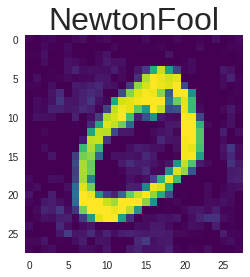

In [12]:
adv_test['NewtonFool'], adv_train['NewtonFool'] = atk_NewtonFool(x_train, x_test, y_train, y_test, classifier)
np.save('adv/test_NewtonFool', adv_test['NewtonFool'])
np.save('adv/train_NewtonFool', adv_train['NewtonFool'])

adv_test['NewtonFool'] = np.load('adv/test_NewtonFool.npy')
adv_train['NewtonFool'] = np.load('adv/train_NewtonFool.npy')

plot(adv_train['NewtonFool'], 1, 'NewtonFool')
print("--- %s minutes ---" % ((time.time() - start_time)/60))

### Universal Perturbation

[Evaluate] Attack: UniPerturb Defense: No Defense
--- 79.18320670127869 minutes ---


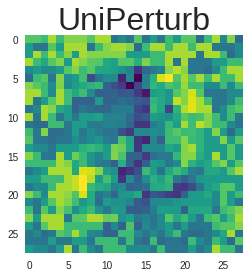

In [13]:
adv_test['UniPerturb'], adv_train['UniPerturb'] = atk_UniPerturb(x_train, x_test, y_train, y_test, classifier)
np.save('adv/test_UniPerturb', adv_test['UniPerturb'])
np.save('adv/train_UniPerturb', adv_train['UniPerturb'])

adv_test['UniPerturb'] = np.load('adv/test_UniPerturb.npy')
adv_train['UniPerturb'] = np.load('adv/train_UniPerturb.npy')

plot(adv_train['UniPerturb'], 1, 'UniPerturb')
print("--- %s minutes ---" % ((time.time() - start_time)/60))

### Plot Adversarial Examples

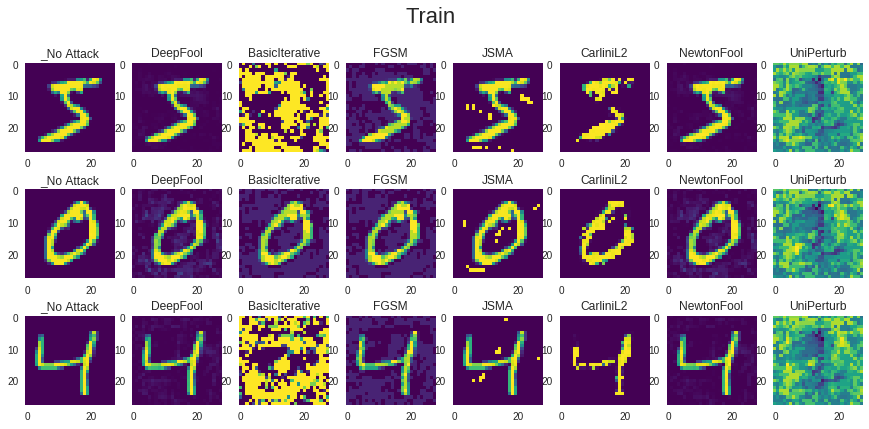

In [14]:
plot_all_adv('Train', adv_train, start=0, end=3, height=2.2)

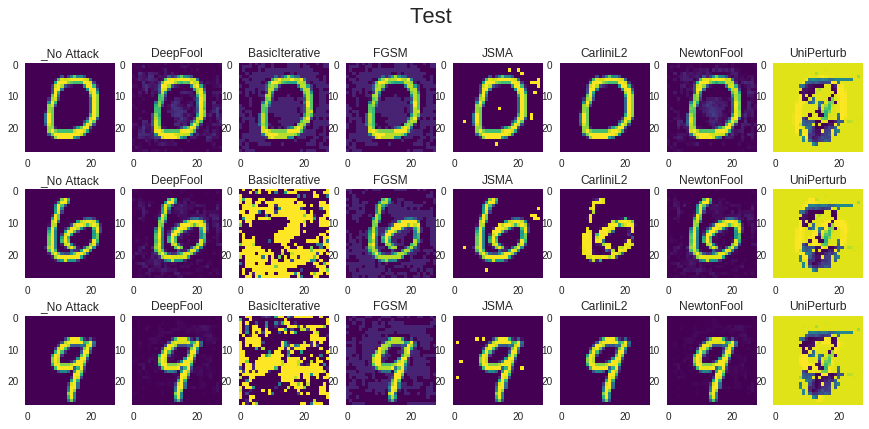

In [15]:
plot_all_adv('Test', adv_test, start=10, end=13, height=2.2)

## Benchmark Attacks against Defenses

In [16]:
evaluate(adv_train['_No Attack'], adv_test['_No Attack'], y_train, y_test, classifier, attack='_No Attack')
for attack in attack_list:
    evaluate(adv_train[attack], adv_test[attack], y_train, y_test, classifier, attack=attack)

K.clear_session()

[Evaluate] Attack: _No Attack Defense: No Defense
[Evaluate] Attack: DeepFool Defense: No Defense
[Evaluate] Attack: BasicIterative Defense: No Defense
[Evaluate] Attack: FGSM Defense: No Defense
[Evaluate] Attack: JSMA Defense: No Defense
[Evaluate] Attack: CarliniL2 Defense: No Defense
[Evaluate] Attack: NewtonFool Defense: No Defense
[Evaluate] Attack: UniPerturb Defense: No Defense


### Defense

In [0]:
x_train_adv_all = np.concatenate((adv_train['DeepFool'],
                            adv_train['BasicIterative'],
                            adv_train['FGSM'],
                            adv_train['JSMA'],
                            adv_train['CarliniL2'],
                            adv_train['NewtonFool'],
                            adv_train['UniPerturb']),
                            axis=0)

x_test_adv_all = np.concatenate((adv_test['DeepFool'],
                           adv_test['BasicIterative'],
                           adv_test['FGSM'],
                           adv_test['JSMA'],
                           adv_test['CarliniL2'],
                           adv_test['NewtonFool'],
                           adv_test['UniPerturb']),
                           axis=0)

In [18]:
def_SpatialSmoothing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)

Epoch 1/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0146 - acc: 0.9055
Epoch 2/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0075 - acc: 0.9526
Epoch 3/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0060 - acc: 0.9622
Epoch 4/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0052 - acc: 0.9674
Epoch 5/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0043 - acc: 0.9732
[Evaluate] Attack: _No Attack Defense: Spatial Smoothing
[Evaluate] Attack: DeepFool Defense: Spatial Smoothing
[Evaluate] Attack: BasicIterative Defense: Spatial Smoothing
[Evaluate] Attack: FGSM Defense: Spatial Smoothing
[Evaluate] Attack: JSMA Defense: Spatial Smoothing
[Evaluate] Attack: CarliniL2 Defense: Spatial Smoothing
[Evaluate] Attack: NewtonFool Defense: Spatial Smoothing
[Evaluate] Attack: UniPerturb Defense: Spatial Smoothing


In [19]:
def_AdversarialTraining(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)

Epoch 1/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0140 - acc: 0.9079
Epoch 2/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0066 - acc: 0.9584
Epoch 3/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0049 - acc: 0.9693
Epoch 4/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0041 - acc: 0.9740
Epoch 5/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0035 - acc: 0.9783
[Evaluate] Attack: _No Attack Defense: Adversarial Training
Epoch 1/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0105 - acc: 0.9324
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0049 - acc: 0.9695
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0035 - acc: 0.9780
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0028 - acc: 0.9829
Epoch 5/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0

In [20]:
def_FeatureSqueezing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)

Epoch 1/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0136 - acc: 0.9111
Epoch 2/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0063 - acc: 0.9592
Epoch 3/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0049 - acc: 0.9693
Epoch 4/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0040 - acc: 0.9748
Epoch 5/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0033 - acc: 0.9796
[Evaluate] Attack: _No Attack Defense: Feature Squeezing
[Evaluate] Attack: DeepFool Defense: Feature Squeezing
[Evaluate] Attack: BasicIterative Defense: Feature Squeezing
[Evaluate] Attack: FGSM Defense: Feature Squeezing
[Evaluate] Attack: JSMA Defense: Feature Squeezing
[Evaluate] Attack: CarliniL2 Defense: Feature Squeezing
[Evaluate] Attack: NewtonFool Defense: Feature Squeezing


In [21]:
def_GaussianAugmentation(x_raw, x_raw_test, y_raw, y_raw_test, x_train_adv_all, x_test_adv_all, y_train, y_test, min_, max_)

Epoch 1/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0187 - acc: 0.8728
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0102 - acc: 0.9337
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0080 - acc: 0.9489
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0067 - acc: 0.9577
Epoch 5/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0059 - acc: 0.9625
[Evaluate] Attack: _No Attack Defense: Gaussian Augmentation
[Evaluate] Attack: DeepFool Defense: Gaussian Augmentation
[Evaluate] Attack: BasicIterative Defense: Gaussian Augmentation
[Evaluate] Attack: FGSM Defense: Gaussian Augmentation
[Evaluate] Attack: JSMA Defense: Gaussian Augmentation
[Evaluate] Attack: CarliniL2 Defense: Gaussian Augmentation
[Evaluate] Attack: NewtonFool Defense: Gaussian Augmentation
[Evaluate] Attack: UniPerturb Defense: Gaussian Augmentation


In [22]:
def_LabelSmoothing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Epoch 1/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0091 - acc: 0.9179
Epoch 2/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0047 - acc: 0.9672
Epoch 3/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0038 - acc: 0.9768
Epoch 4/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0032 - acc: 0.9821
Epoch 5/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0027 - acc: 0.9861
[Evaluate] Attack: _No Attack Defense: Label Smoothing
[Evaluate] Attack: DeepFool Defense: Label Smoothing
[Evaluate] Attack: BasicIterative Defense: Label Smoothing
[Evaluate] Attack: FGSM Defense: Label Smoothing
[Evaluate] Attack: JSMA Defense: Label Smoothing
[Evaluate] Attack: CarliniL2 Defense: Label Smoothing
[Evaluate] Attack: NewtonFool Defense: Label Smoothing
[Evaluate] Attack: UniPerturb Defense: Label Smoothing
--- 86.83219383557638 minutes ---


# Results

In [23]:
results_df = pd.DataFrame(results)
results_df

,BasicIterative (Test),BasicIterative (Train),CarliniL2 (Test),CarliniL2 (Train),DeepFool (Test),DeepFool (Train),FGSM (Test),FGSM (Train),JSMA (Test),JSMA (Train),NewtonFool (Test),NewtonFool (Train),UniPerturb (Test),UniPerturb (Train),_No Attack (Test),_No Attack (Train)
Adversarial Training,96.92,98.001667,93.56,98.376667,97.17,98.563333,97.36,98.678333,89.61,98.775000,97.40,98.676667,10.28,92.163333,96.980,98.015000
Feature Squeezing,16.48,16.210000,77.52,93.815000,96.16,97.350000,94.00,94.425000,74.26,66.231667,96.53,97.538333,NaN,NaN,96.830,97.956667
Gaussian Augmentation,16.49,16.195000,87.99,95.740000,95.93,96.460000,87.75,87.031667,94.97,93.448333,96.11,96.658333,9.82,25.293333,92.285,96.365000
Label Smoothing,15.24,14.933333,81.12,95.263333,87.01,88.876667,48.31,47.575000,77.30,65.400000,92.89,94.545000,9.58,18.101667,97.590,98.670000
No Defense,16.62,16.288333,68.15,92.196667,78.52,79.523333,17.23,16.598333,0.43,0.161667,87.04,86.955000,9.74,9.930000,97.000,98.070000
Spatial Smoothing,15.08,14.840000,76.23,93.591667,88.46,89.648333,46.49,45.035000,95.67,95.083333,92.38,93.396667,9.85,9.930000,96.570,97.661667


Text(0.5,1,'No Defense')

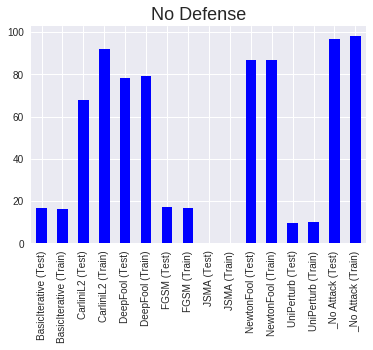

In [24]:
result_path = 'results'
if not os.path.exists(result_path):
   os.makedirs(result_path)

results_df.to_pickle('results/attack_defense_results.pkl')
results_df.loc['No Defense'].plot.bar(color='b')
plt.title('No Defense', fontsize=18)

Text(0.5,1,'Feature Squeezing')

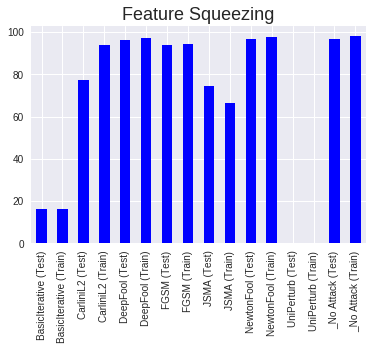

In [25]:
results_df.loc['Feature Squeezing'].plot.bar(color='b')
plt.title('Feature Squeezing',fontsize=18)

Text(0.5,1,'Adversarial Training')

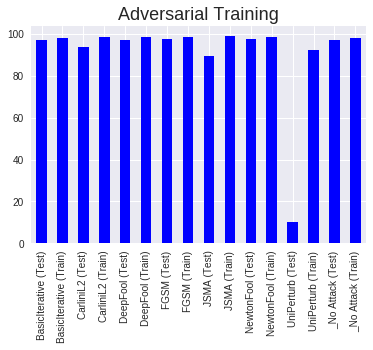

In [26]:
results_df.loc['Adversarial Training'].plot.bar(color='b')
plt.title('Adversarial Training',fontsize=18)

Text(0.5,1,'Gaussian Augmentation')

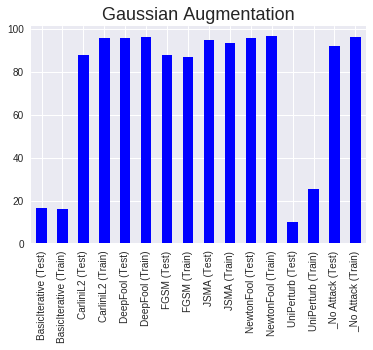

In [27]:
results_df.loc['Gaussian Augmentation'].plot.bar(color='b')
plt.title('Gaussian Augmentation',fontsize=18)

Text(0.5,1,'Label Smoothing')

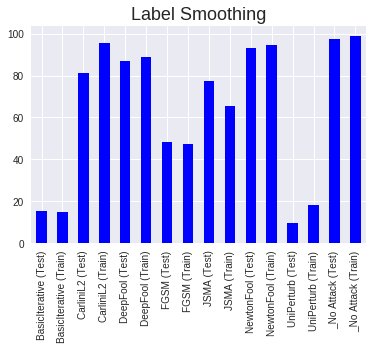

In [28]:
results_df.loc['Label Smoothing'].plot.bar(color='b')
plt.title('Label Smoothing', fontsize=18)

Text(0.5,1,'Spatial Smoothing')

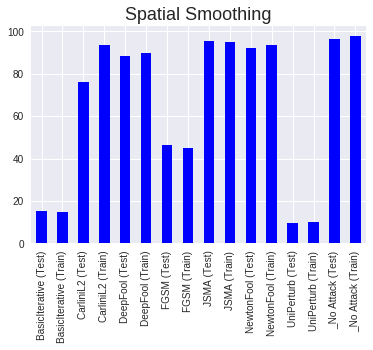

In [29]:
results_df.loc['Spatial Smoothing'].plot.bar(color='b')
plt.title('Spatial Smoothing', fontsize=18)

In [30]:
!zip -r simpleNN_2_layer.zip ./results ./adv

  adding: results/ (stored 0%)
  adding: results/attack_defense_results.pkl (deflated 38%)
  adding: adv/ (stored 0%)
  adding: adv/train_NewtonFool.npy (deflated 38%)
  adding: adv/train_FGSM.npy (deflated 86%)
  adding: adv/test_CarliniL2.npy (deflated 68%)
  adding: adv/train_JSMA.npy (deflated 91%)
  adding: adv/test_DeepFool.npy (deflated 34%)
  adding: adv/train_UniPerturb.npy (deflated 83%)
  adding: adv/train_BasicIterative.npy (deflated 88%)
  adding: adv/test_NewtonFool.npy (deflated 38%)
  adding: adv/train_CarliniL2.npy (deflated 87%)
  adding: adv/test_BasicIterative.npy (deflated 88%)
  adding: adv/test_FGSM.npy (deflated 86%)
  adding: adv/train_DeepFool.npy (deflated 34%)
  adding: adv/test_UniPerturb.npy (deflated 85%)
  adding: adv/test_JSMA.npy (deflated 91%)
